# Data Integration with Jupyter



In this notebook, we want to explore, how Jupyter can be used to process and integrate data from various sources. Our data set consist of publicly available data from the EU about funded projects in the Horizon 2020 program, which is publicly available as CSV. We will add population data provided by the World Bank, mainly because it is available in XML. 

Here are the download links:

- [Project data](https://data.europa.eu/euodp/de/data/dataset/cordisH2020projects/resource/010f269b-9ee3-45a0-afea-c43aa1ef61ac), [CSV file](http://cordis.europa.eu/data/cordis-h2020projects.csv)
- [Project publication data](https://data.europa.eu/euodp/de/data/dataset/cordisH2020projects/resource/e3e6a3d5-6c67-4fca-b4fa-397e6a888300), [CSV file](http://cordis.europa.eu/data/cordis-h2020projectPublications.csv)
- [Population data](https://data.worldbank.org/indicator/SP.POP.TOTL), [zipped XML](http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=xml)
- [Country Codes ISO](https://datahub.io/core/country-codes), [JSON file](https://datahub.io/core/country-codes/r/country-codes.json)
- [Country Codes EU](https://data.europa.eu/euodp/en/data/dataset/cordisref-data/resource/40e08e83-6cf3-4bf0-afe8-d84543186dfc), [CSV file](http://cordis.europa.eu/data/reference/cordisref-countries.csv)

## Imports and preparation

First, we will import all modules that we need. When we realize that we need another module, we include it here at the beginning of the notebook as well. This way, we always can easily see what the requirements of the notebook are.

In [6]:
import csv
import json
import collections
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline


Next, we open the file and print the first line. This way, we see, if headers in the file are present and what field delimiter is used.

In [7]:
f = open("data/cordis-h2020projects.csv", "r", encoding='utf-8', newline="")
print(f.readline())

rcn;id;acronym;status;programme;topics;frameworkProgramme;title;startDate;endDate;projectUrl;objective;totalCost;ecMaxContribution;call;fundingScheme;coordinator;coordinatorCountry;participants;participantCountries;subjects



As we probably want to read through the file several times (we don't care about performance, don't we...), we define a function that puts the file cursor back at the beginning of the file and creates a new CSV [DictReader](https://docs.python.org/3/library/csv.html#csv.DictReader):

In [8]:
def file_reset():
    global reader
    f.seek(0)
    reader = csv.DictReader(f, delimiter=";", )
file_reset()

In [9]:
overall = 0
coordinator = collections.Counter()
for rn, row in enumerate(reader):
    overall += 1
    if 'coordinatorCountry' in row:
        coordinator[row["coordinatorCountry"]] += 1
    else:
        print('Row {}: No coordinator country.'.format(rn))
print(coordinator)
print('Overall number of rows: {}'.format(overall))
file_reset()

Counter({'UK': 4313, 'ES': 3062, 'DE': 2748, 'FR': 2356, 'IT': 2215, 'NL': 1725, 'CH': 940, 'BE': 932, 'DK': 838, 'SE': 761, 'IL': 666, 'AT': 662, 'IE': 576, 'FI': 510, 'PT': 472, 'EL': 456, 'NO': 451, 'PL': 235, 'HU': 169, 'CZ': 139, 'TR': 139, 'SI': 137, 'EE': 134, 'CY': 107, 'IS': 106, 'RO': 72, 'LT': 62, 'SK': 57, 'LU': 54, 'BG': 49, 'RS': 44, 'LV': 41, 'HR': 35, 'MT': 27, 'UA': 21, 'BA': 8, 'FO': 7, 'AM': 6, 'MK': 6, 'TN': 6, 'MD': 5, 'ME': 4, 'KE': 2, 'GE': 1, 'CL': 1, 'GL': 1, 'US': 1, 'AI': 1, 'ZA': 1, 'UY': 1})
Overall number of rows: 25362


## A first research question

What country has the most coordinators per capita, i.e., relative to its overall population?

This question can be answered with the data from the world bank. Please have the XML file unzipped in your data folder.

Again, we have a quick look at the actual file, this time the first 10 lines. Don't forget to reset to the beginning of the file!

In [10]:
popfile = open("data/API_SP.POP.TOTL_DS2_en_xml_v2_151522.xml", 'r', encoding='utf-8', newline="")
for l in range(10):
    print(popfile.readline().rstrip())

﻿<?xml version="1.0" encoding="utf-8"?>
<Root xmlns:wb="http://www.worldbank.org">
  <data>
    <record>
      <field name="Country or Area" key="ABW">Aruba</field>
      <field name="Item" key="SP.POP.TOTL">Population, total</field>
      <field name="Year">1960</field>
      <field name="Value">54211</field>
    </record>
    <record>


Hmm, unfortunately, there is a problem with this dataset, it uses three letter ISO country codes, while our EU dataset uses two letter EU-specific codes. Why can't data not be more homogenous...

But fear not, we will also bridge this gap, of course by accessing even more data. This time, we use the data provided by datahub.io, and to see one more format, we use the JSON version. This gets us two letter ISO codes. With one more CSV file, we can obtain EU codes.


In [11]:
cc = json.load(open('data/country-codes.json', 'r', encoding='utf-8'))
iso2 = {}
for c in cc:
    iso2[c['ISO3166-1-Alpha-3']] = c['ISO3166-1-Alpha-2']
    
# Now, we can easily look up 2 letter codes by means of a 3 letter code"
print("United Kingdom two letter ISO:", iso2['GBR'])

eu = {}
eucc = {} 
eucc_file = open('data/cordisref-countries.csv', 'r', encoding='utf-8-sig')
for c in csv.DictReader(eucc_file, delimiter=';'):
    eucc[c['isoCode']] = c['euCode']

print("United Kingdom two letter EU:", eucc[iso2['GBR']])

United Kingdom two letter ISO: GB
United Kingdom two letter EU: UK


Back to our population data. Next, we parse the XML. As we can see the structure above, this is fairly straight-forward.

In [12]:
# as we read already some line, reset the file cursor
popfile.seek(0)
# data is within the first child node of the root node.
data = ET.parse(popfile).getroot()[0]


In [13]:
pops = {}
for child in data:
    if child.find("field[@name='Year']").text == '2018':
        ccode3 = child.find("field[@name='Country or Area']").get('key')
        if ccode3 in iso2:
            ccode2 = eucc[iso2[ccode3]]
        else:
            # This is an area, we can proceed to next child
            continue
        if ccode2 in coordinator:
            pop = int(child.find("field[@name='Value']").text)
            pops[ccode2] = pop
pops

{'AM': 2951776,
 'AT': 8847037,
 'BE': 11422068,
 'BG': 7024216,
 'BA': 3323929,
 'CH': 8516543,
 'CL': 18729160,
 'CY': 1189265,
 'CZ': 10625695,
 'DE': 82927922,
 'DK': 5797446,
 'ES': 46723749,
 'EE': 1320884,
 'FI': 5518050,
 'FR': 66987244,
 'FO': 48497,
 'UK': 66488991,
 'GE': 3731000,
 'EL': 10727668,
 'GL': 56025,
 'HR': 4089400,
 'HU': 9768785,
 'IE': 4853506,
 'IS': 353574,
 'IL': 8883800,
 'IT': 60431283,
 'KE': 51393010,
 'LT': 2789533,
 'LU': 607728,
 'LV': 1926542,
 'MD': 3545883,
 'MK': 2082958,
 'MT': 483530,
 'ME': 622345,
 'NL': 17231017,
 'NO': 5314336,
 'PL': 37978548,
 'PT': 10281762,
 'RO': 19473936,
 'RS': 6982084,
 'SK': 5447011,
 'SI': 2067372,
 'SE': 10183175,
 'TN': 11565204,
 'TR': 82319724,
 'UA': 44622516,
 'UY': 3449299,
 'US': 327167434,
 'ZA': 57779622}

Finally, we can answer our question:

In [14]:
coord_percap = collections.Counter()
for c in coordinator:
    if c not in pops:
        print("No population data for", c)
        continue
    coord_percap[c] = coordinator[c] / pops[c] * 1000000    
coord_percap.most_common(10)

No population data for AI


[('IS', 299.79579946489275),
 ('DK', 144.54640888418797),
 ('FO', 144.33882508196385),
 ('IE', 118.67709651538496),
 ('CH', 110.37342264343643),
 ('EE', 101.44721262427284),
 ('NL', 100.11016761227734),
 ('FI', 92.42395411422514),
 ('CY', 89.9715370417863),
 ('LU', 88.85554063660058)]

<BarContainer object of 10 artists>

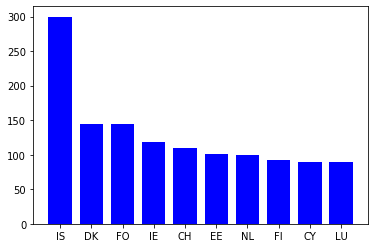

In [22]:
plt.bar([c[0] for c in coord_percap.most_common(10)], [c[1] for c in coord_percap.most_common(10)], 0.75, color="blue")

